In [1]:
tf=True

if tf:
    !pip install git+https://github.com/krivovsv/optimalrcs.git
else:
    !pip install git+https://github.com/krivovsv/optimalrcs.git@development/cupy


  Cloning https://github.com/krivovsv/optimalrcs.git to /tmp/pip-req-build-0hjfdclc
  Running command git clone --filter=blob:none --quiet https://github.com/krivovsv/optimalrcs.git /tmp/pip-req-build-0hjfdclc
  Resolved https://github.com/krivovsv/optimalrcs.git to commit 318dc69ed42edeea4eab24fbfe557dd94d768c1b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


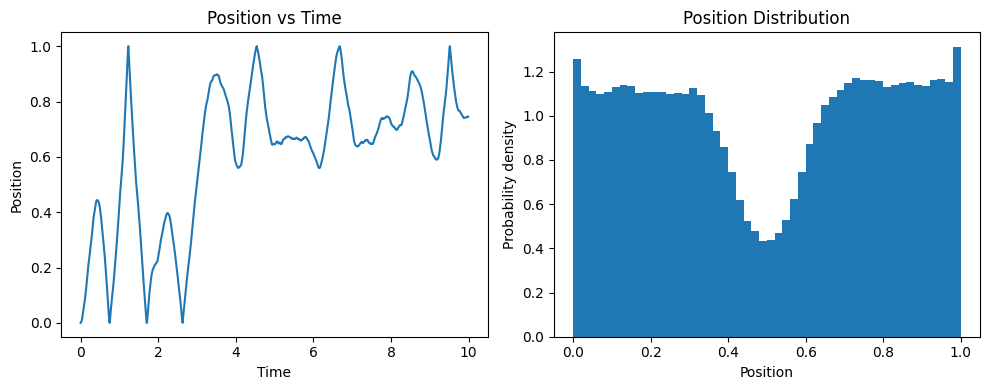

#=0, xent=0.436586, mse=0.129629, sdzq=167.519, dzq=639.904, dr2=98.2347, auc=0.877221, |dx|=0.323689, time=8.36231
#=1000, xent=0.432901, mse=0.127237, sdzq=141.13, dzq=549.17, dr2=94.1338, auc=0.877221, |dx|=0.0145302, time=81.0506
#=2000, xent=0.432901, mse=0.127237, sdzq=141.13, dzq=549.17, dr2=94.1338, auc=0.877221, |dx|=1.78777e-07, time=154.651
#=0, xent=0.432901, mse=0.127237, sdzq=141.128, dzq=549.182, dr2=94.1339, auc=0.877221, |dx|=2.1229e-05, time=4.75282
#=1000, xent=0.251862, mse=0.0735658, sdzq=12.8398, dzq=35.6827, dr2=3182.24, auc=0.959702, |dx|=0.229358, time=78.3567
#=2000, xent=0.251255, mse=0.0734062, sdzq=9.53131, dzq=24.9838, dr2=3209.59, auc=0.959879, |dx|=0.00645523, time=150.476
#=3000, xent=0.251019, mse=0.0733502, sdzq=8.14129, dzq=22.6559, dr2=3223.26, auc=0.959935, |dx|=0.00287198, time=223.33
#=4000, xent=0.250907, mse=0.0733236, sdzq=6.76587, dzq=19.7382, dr2=3228.47, auc=0.959964, |dx|=0.00176681, time=295.952
#=5000, xent=0.250822, mse=0.073293, sdzq=7

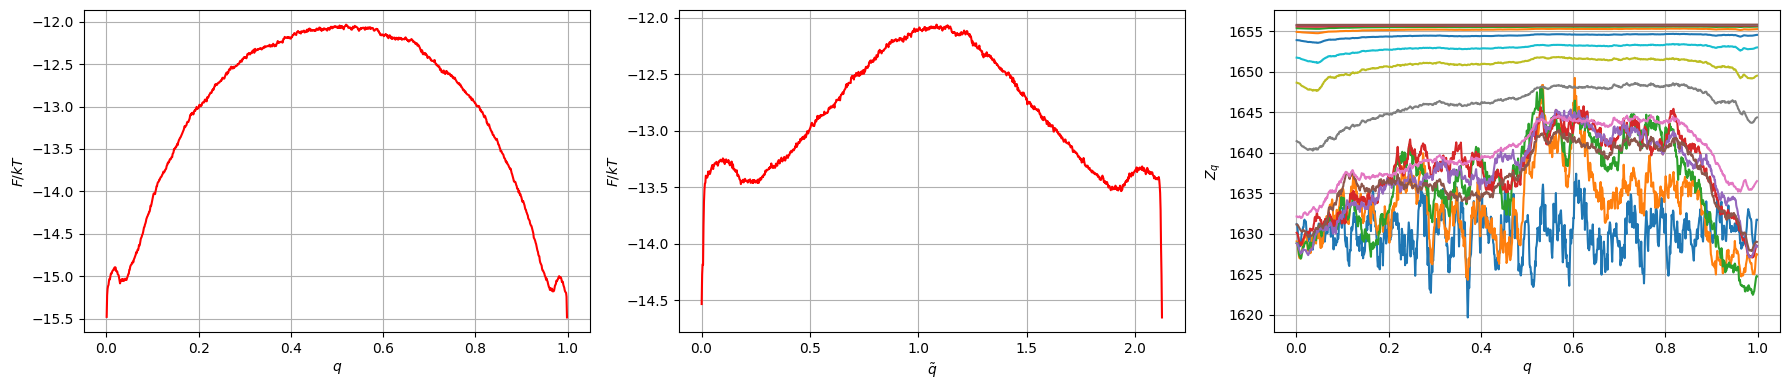

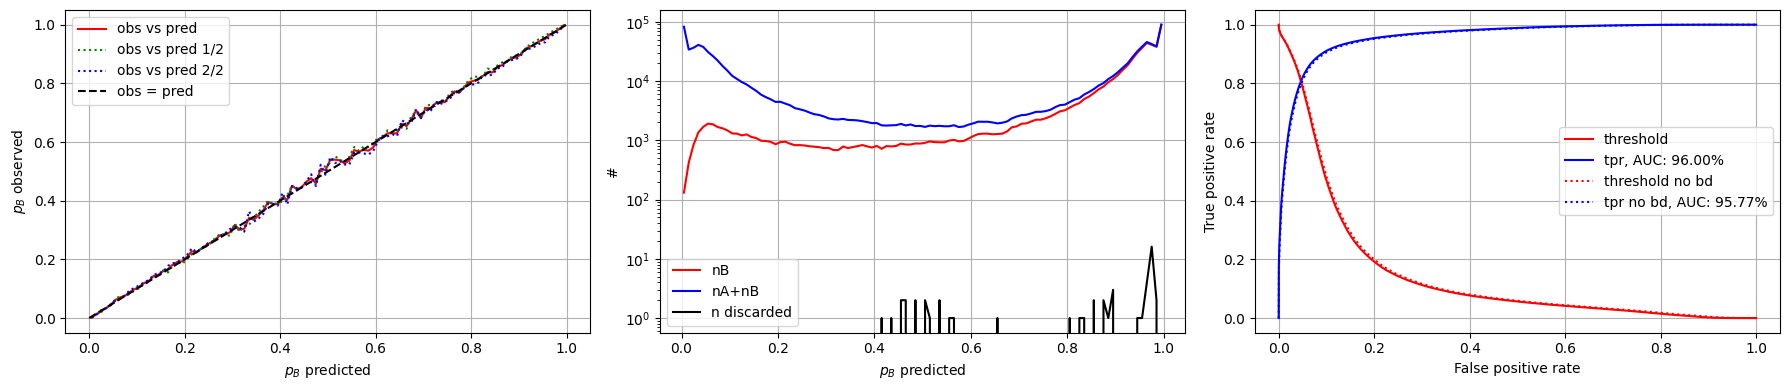

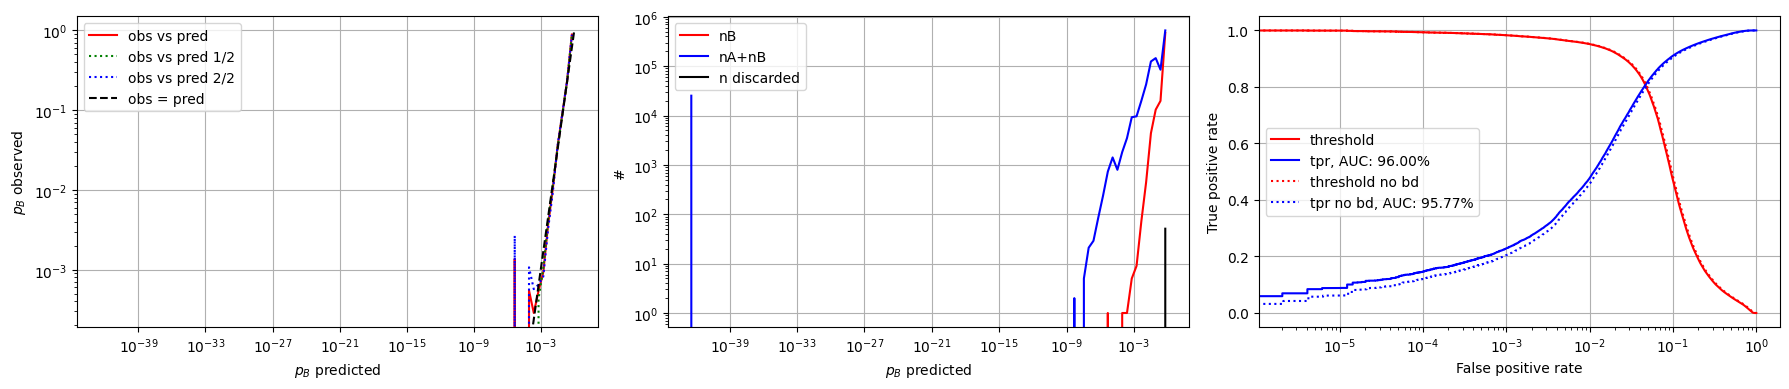

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
#import optimalrcs
from optimalrcs import optimalrcs

# Parameters
m = 1.0  # mass
gamma = 1.0  # friction coefficient
k_B = 1.0  # Boltzmann constant
T = 1.0  # temperature
dt = 0.01  # time step
num_steps = 1000000  # number of steps
x0 = 0.0  # initial position
v0 = 0.0  # initial velocity

# Potential function U(x)
def potential(x):
    return math.exp(-(x-0.5)**2/0.01)

# Gradient of the potential (force)
def force(x):
    return (x-0.5)*2/0.01*math.exp(-(x-0.5)**2/0.01)

# Initialize arrays to store positions and velocities
positions = np.zeros(num_steps)
velocities = np.zeros(num_steps)

# Initial conditions
positions[0] = x0
velocities[0] = v0


np.random.seed(0)
# Simulation loop
for i in range(1, num_steps):
    x = positions[i-1]
    v = velocities[i-1]

    # Calculate forces
    F = force(x)

    # Generate random noise
    xi = np.random.normal(0, 1)

    # Update velocity and position using the Euler-Maruyama method
    v = v + (-gamma * v + F / m) * dt + np.sqrt(2 * gamma * k_B * T / m) * xi * np.sqrt(dt)
    x = x + v * dt

    # Apply boundary conditions (reflective walls)
    if x < 0:
        x = 0
        v = -v  # Reflect velocity
    elif x > 1:
        x = 1
        v = -v  # Reflect velocity

    # Store positions and velocities
    positions[i] = x
    velocities[i] = v

# Plot the results
time = np.linspace(0, num_steps * dt, num_steps)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(time[:1000], positions[:1000])
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position vs Time')

plt.subplot(1, 2, 2)
plt.hist(positions, bins=50, density=True)
plt.xlabel('Position')
plt.ylabel('Probability density')
plt.title('Position Distribution')

plt.tight_layout()
plt.show()


i_traj=np.ones_like(positions)
t_traj=np.asarray(range(len(positions)))
from scipy.interpolate import griddata

def qxv(q,x,v):

    xi = np.linspace(0, 1, 100)
    vi = np.linspace(-3, 3, 100)
    xi, vi = np.meshgrid(xi, vi)

    qi = griddata((x, v), q, (xi, vi), method='cubic')
    qi = np.clip(qi, 0.0001, 1-0.0001)
    levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]


    # Create the contour plot with specified contour lines
    contour = plt.contourf(xi, vi, qi, levels=levels, cmap="RdBu_r")
    contour_lines = plt.contour(xi, vi, qi, levels=levels, colors='grey', alpha=0.5)

    plt.colorbar(contour, label='q value')
    plt.xlabel('x')
    plt.ylabel('v')
    plt.title('Contour plot of q(x, v)')
    plt.grid()
    plt.show()


def comp_y(): return positions

history=[0,1]
yr_type=['y(t-d),y(t)']

q=optimalrcs.CommittorNE(boundary0=positions<0.01,boundary1=positions>0.99, i_traj=i_traj, t_traj=t_traj)
np.random.seed(0)
optimalrcs.envelope_scale=1000000
q.fit_transform(comp_y,history_delta_t=history,gamma=0,max_iter=2000,history_type=yr_type)
optimalrcs.envelope_scale=0.01
q.fit_transform(comp_y,history_delta_t=history,gamma=0,max_iter=10000,history_type=yr_type)

q.plots_feps(delta_t_sim=0.01)
q.plots_obs_pred()
q.plots_obs_pred(log_scale=True)
plt.show()

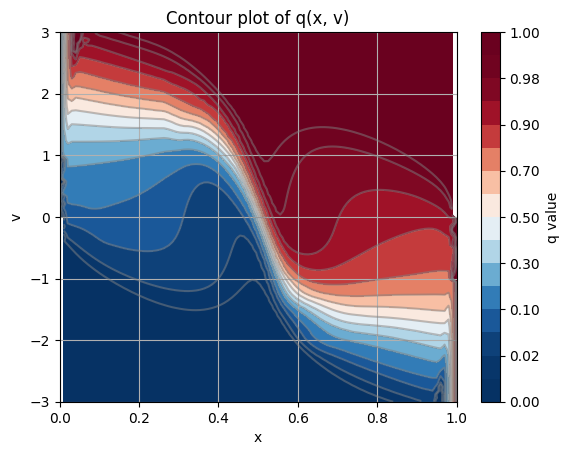

In [3]:
if tf:
    qxv(q.r_traj.numpy(),positions,velocities)
else:
    qxv(q.r_traj.get(),positions,velocities)

Time-reversed dynamics for backward committor

#=0, xent=0.435278, mse=0.129063, sdzq=167.328, dzq=639.844, dr2=98.2347, auc=0.878153, |dx|=0.323987, time=4.98639
#=1000, xent=0.431495, mse=0.126685, sdzq=141.113, dzq=549.584, dr2=94.1328, auc=0.878153, |dx|=0.014455, time=78.8128
#=2000, xent=0.431495, mse=0.126685, sdzq=141.113, dzq=549.584, dr2=94.1328, auc=0.878153, |dx|=7.17399e-08, time=151.389
#=0, xent=0.431492, mse=0.126685, sdzq=141.096, dzq=549.546, dr2=94.1329, auc=0.878153, |dx|=4.23919e-05, time=4.65054
#=1000, xent=0.356374, mse=0.107272, sdzq=442.508, dzq=1018.78, dr2=978.764, auc=0.950416, |dx|=0.182063, time=76.1788
#=2000, xent=0.251863, mse=0.0735585, sdzq=18.3353, dzq=50.7292, dr2=3153.63, auc=0.9599, |dx|=0.171545, time=147.482
#=3000, xent=0.250425, mse=0.0731695, sdzq=15.4369, dzq=37.9595, dr2=3202.56, auc=0.960294, |dx|=0.00933454, time=218.721
#=4000, xent=0.249966, mse=0.0730587, sdzq=14.5517, dzq=36.005, dr2=3218.51, auc=0.960395, |dx|=0.00397091, time=289.951
#=5000, xent=0.2497, mse=0.0729782, sdzq=11.

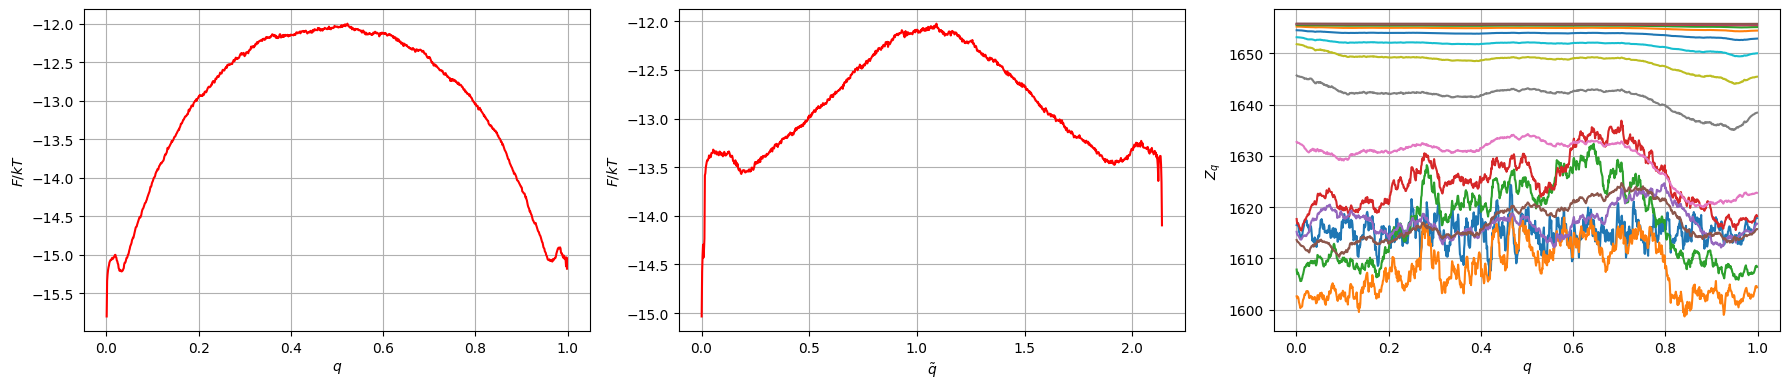

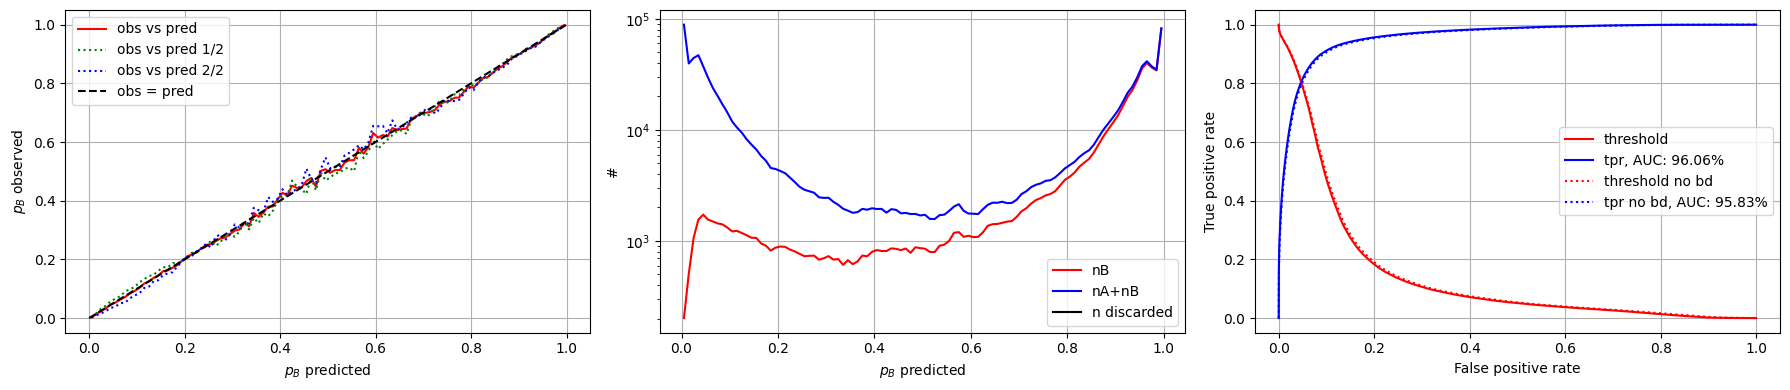

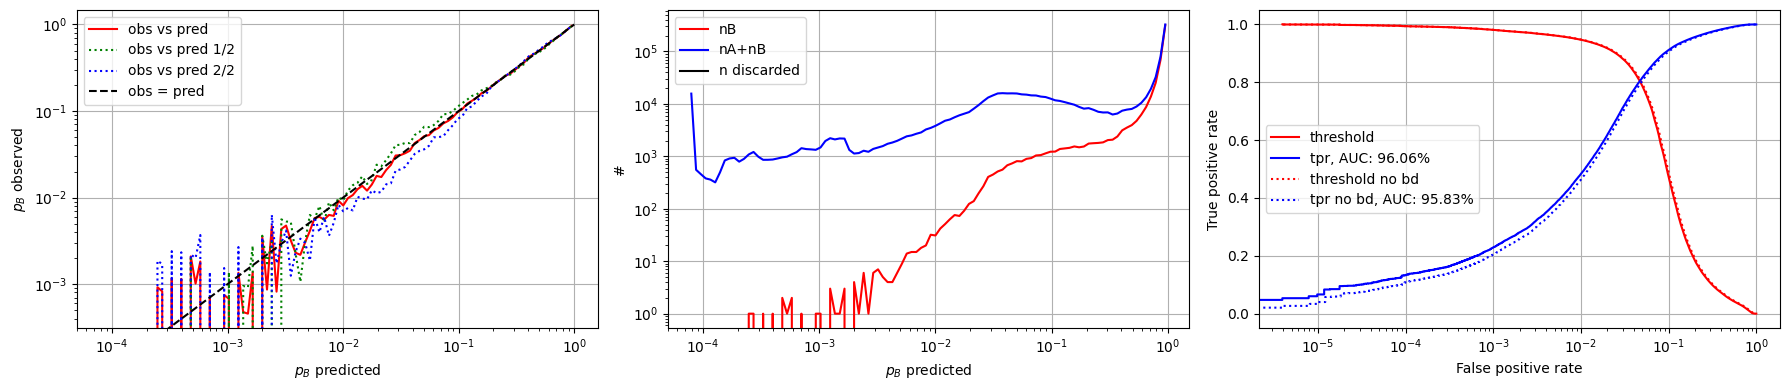

In [4]:
positions_r=positions[::-1].copy()


def comp_y(): return positions_r

history=[0,1]
yr_type=['y(t-d),y(t)']

q_r=optimalrcs.CommittorNE(boundary0=positions_r>0.99,boundary1=positions_r<0.01, i_traj=i_traj, t_traj=t_traj)
np.random.seed(0)
optimalrcs.envelope_scale=1000000
q_r.fit_transform(comp_y,history_delta_t=history,gamma=0,max_iter=2000,history_type=yr_type)
optimalrcs.envelope_scale=0.01
q_r.fit_transform(comp_y,history_delta_t=history,gamma=0,max_iter=10000,history_type=yr_type)

q_r.plots_feps(delta_t_sim=0.01)
q_r.plots_obs_pred()
q_r.plots_obs_pred(log_scale=True)
plt.show()

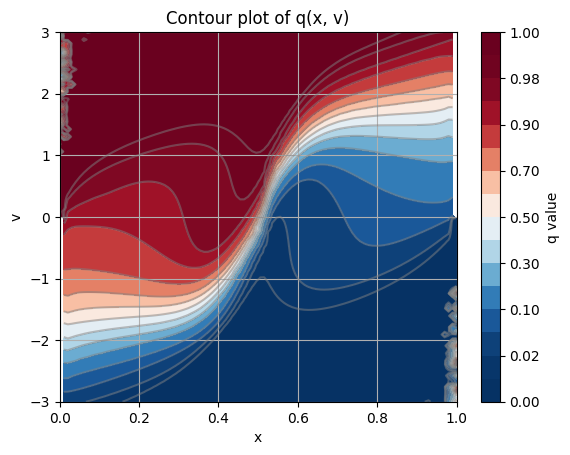

In [5]:
if tf:
    qxv(q_r.r_traj.numpy()[::-1],np.roll(positions,-1),np.roll(velocities,-1))
else:
    qxv(q_r.r_traj.get()[::-1],np.roll(positions,-1),np.roll(velocities,-1))